In [11]:
!pip install aiapy 
!pip install numpydoc 
!wget https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
!unzip sunspot_dataset.zip 

--2024-09-25 20:05:59--  https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/observethesun/sunspot_groups/main/dataset/sunspot_dataset.zip [following]
--2024-09-25 20:06:00--  https://raw.githubusercontent.com/observethesun/sunspot_groups/main/dataset/sunspot_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14406615 (14M) [application/zip]
Saving to: 'sunspot_dataset.zip.1'

sunspot_dataset.zip 100%[===================>]  13.74M  --.-KB/s    in 0.09s   

2024-09-25 20:06:00 (155 MB/s) - 'sunspot_dataset.z

In [13]:
import git
git.Repo.clone_from('https://github.com/observethesun/helio.git', '/kaggle/working/module_helio')

GitCommandError: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/observethesun/helio.git /kaggle/working/module_helio
  stderr: 'fatal: destination path '/kaggle/working/module_helio' already exists and is not an empty directory.
'

In [14]:
import os
import zipfile
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import torch
import torch.optim as optim
import torchvision.models as models

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from tqdm import tqdm

import sys
sys.path.append('/kaggle/working/module_helio')

from helio import FilesIndex, HelioBatch, BatchSampler
from helio import VAE

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [43]:
index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
index

,img
FilesIndex,
201007230452_63,/kaggle/working/sunspot_dataset/201007230452_6...
201007240414_63,/kaggle/working/sunspot_dataset/201007240414_6...
201007250447_63,/kaggle/working/sunspot_dataset/201007250447_6...
201007250447_64,/kaggle/working/sunspot_dataset/201007250447_6...
201007260349_63,/kaggle/working/sunspot_dataset/201007260349_6...
...,...
202008120532_31,/kaggle/working/sunspot_dataset/202008120532_3...
202008120532_33,/kaggle/working/sunspot_dataset/202008120532_3...
202008180351_34,/kaggle/working/sunspot_dataset/202008180351_3...


In [37]:
npz_file = '/kaggle/working/sunspot_dataset/201109080403_192.npz'

In [39]:
data = sparse.load_npz(npz_file).toarray().reshape(256, 256, 3)
data.shape

In [45]:
def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

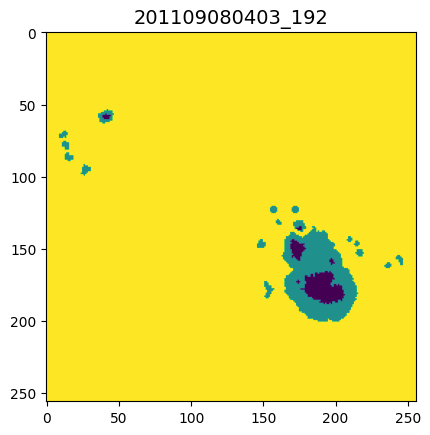

In [46]:
batch = (HelioBatch(index.loc[['201109080403_192']])
             .load('img', sparse=True)
             .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
             .apply(transform_channels, src='img'))
plt.imshow(1-np.squeeze(batch.img[0]))
plt.title(batch.indices[0], fontsize=14)
plt.show()

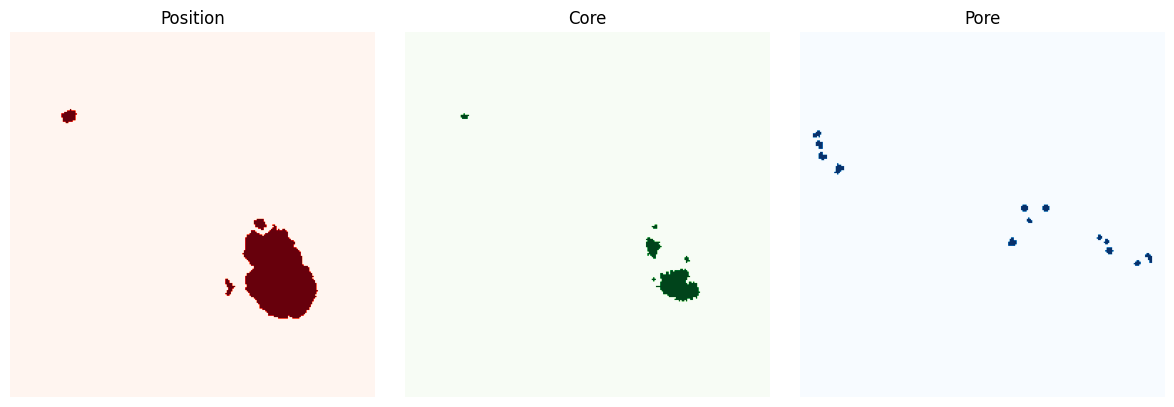

In [48]:
# Извлечение каждого канала
red_channel = data[:, :, 0]
green_channel = data[:, :, 1]
blue_channel = data[:, :, 2]

# Визуализация каждого канала
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title('Spot position')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title('Core')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Pore')
plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import os
import zipfile
import random

import numpy as np
import pandas as pd

In [2]:
prop_emb = pd.read_csv('/kaggle/input/sunspot-group-properties/sunspot_group_properties.csv')
prop_emb

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0
0,201007230452_63,2010-07-23 04:52:00,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,17,16,6,-2.385188,210,5.0,230.3
1,201007240414_63,2010-07-24 04:14:00,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,9,4,3,-23.918642,241,5.1,217.4
2,201007250447_64,2010-07-25 04:47:00,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,1,0,0,3.633730,78,5.2,203.9
3,201007250447_63,2010-07-25 04:47:00,63,-20.642013,-23.509269,-26.938974,204.949343,201.557542,195.071475,297.469260,12,7,3,-32.418379,232,5.2,203.9
4,201007260349_63,2010-07-26 03:49:00,63,-20.258757,-23.032369,-26.887540,205.544796,202.530956,198.138547,193.869511,9,3,2,-40.638848,255,5.0,191.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,202008120532_31,2020-08-12 05:32:00,31,23.913506,23.744530,23.590821,23.358192,23.202173,23.017393,3.627088,1,1,1,-20.556045,24,6.5,350.2
8494,202008120532_33,2020-08-12 05:32:00,33,-18.919818,-19.017301,-19.124511,297.120542,296.952145,296.788714,3.165966,1,0,0,15.018361,19,6.5,350.2
8495,202008180351_34,2020-08-18 03:51:00,34,18.506278,18.293351,18.088359,296.554881,296.295343,296.019040,8.938790,1,1,1,-6.980488,44,6.8,271.9
8496,202008190344_35,2020-08-19 03:44:00,35,16.197485,15.355416,14.602672,254.801501,254.371843,253.992354,5.245143,2,0,0,-68.521065,50,6.8,258.7


In [3]:
df = prop_emb

In [4]:
df.loc[df['fname'] == '201109080403_192']

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0
923,201109080403_192,2011-09-08 04:03:00,192,19.711457,14.009781,12.098522,230.465151,226.276799,217.392862,370.975155,17,6,3,28.584423,284,7.2,191.9


* fname - filename of the sunspot group in the dataset (also the filename format YYYYMMDDHHMM_N encodes date, time of observation and sunspot group number)
* date - date and time of observation
* group_number - sunspot group number
* lat_max - maximal heliographic latitude of sunspot group pixels
* lat_mean - mean heliographic latitude of the sunspot group
* lat_min - minimal heliographic latitude of sunspot group pixels
* long_max - maximal Carrington longitude of sunspot group pixels
* long_mean - mean Carrington longitude of the sunspot group
* long_min - minimal Carrington longitude of sunspot group pixels
* area - sunspot group area in MSH (millionth of the solar hemisphere)
* nspots - total number of spots and pores in the sunspot group
* ncores - number of cores in the sunspot group
* nspots_with_cores - number of spots with cores
* tilt - inclination (in degrees, positive clockwise) of the regression line fitted to the sunspot group
* complexity - integer number, reflecting complexity of the sunspot group. Defined a the number of principal components, at which the reconstruction error is half the reconstruction error for the first principal component
* B0 - B0 angle for date and time of the observation
* L0 - L0 angle for date and time of the observation

In [13]:
df = df[['fname','nspots','ncores','nspots_with_cores', 'lat_max', 'lat_min', 'long_max','long_min']]
df

,fname,nspots,ncores,nspots_with_cores,lat_max,lat_min,long_max,long_min
0,201007230452_63,17,16,6,-20.896839,-26.597699,204.043367,194.646751
1,201007240414_63,9,4,3,-21.131845,-27.108871,204.704703,194.511357
2,201007250447_64,1,0,0,23.580196,23.101008,149.500812,148.527835
3,201007250447_63,12,7,3,-20.642013,-26.938974,204.949343,195.071475
4,201007260349_63,9,3,2,-20.258757,-26.887540,205.544796,198.138547
...,...,...,...,...,...,...,...,...
8493,202008120532_31,1,1,1,23.913506,23.590821,23.358192,23.017393
8494,202008120532_33,1,0,0,-18.919818,-19.124511,297.120542,296.788714
8495,202008180351_34,1,1,1,18.506278,18.088359,296.554881,296.019040
8496,202008190344_35,2,0,0,16.197485,14.602672,254.801501,253.992354


In [5]:
def euclidean_distance(row):
    return np.sqrt((row['lat_max'] - row['lat_min']) ** 2 + (row['long_max'] - row['long_min']) ** 2)

In [6]:
df['spot_lenth'] = df.apply(euclidean_distance, axis=1)

In [7]:
df

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0,spot_lenth
0,201007230452_63,2010-07-23 04:52:00,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,17,16,6,-2.385188,210,5.0,230.3,10.990732
1,201007240414_63,2010-07-24 04:14:00,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,9,4,3,-23.918642,241,5.1,217.4,11.816477
2,201007250447_64,2010-07-25 04:47:00,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,1,0,0,3.633730,78,5.2,203.9,1.084576
3,201007250447_63,2010-07-25 04:47:00,63,-20.642013,-23.509269,-26.938974,204.949343,201.557542,195.071475,297.469260,12,7,3,-32.418379,232,5.2,203.9,11.714265
4,201007260349_63,2010-07-26 03:49:00,63,-20.258757,-23.032369,-26.887540,205.544796,202.530956,198.138547,193.869511,9,3,2,-40.638848,255,5.0,191.2,9.939481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,202008120532_31,2020-08-12 05:32:00,31,23.913506,23.744530,23.590821,23.358192,23.202173,23.017393,3.627088,1,1,1,-20.556045,24,6.5,350.2,0.469330
8494,202008120532_33,2020-08-12 05:32:00,33,-18.919818,-19.017301,-19.124511,297.120542,296.952145,296.788714,3.165966,1,0,0,15.018361,19,6.5,350.2,0.389883
8495,202008180351_34,2020-08-18 03:51:00,34,18.506278,18.293351,18.088359,296.554881,296.295343,296.019040,8.938790,1,1,1,-6.980488,44,6.8,271.9,0.679545
8496,202008190344_35,2020-08-19 03:44:00,35,16.197485,15.355416,14.602672,254.801501,254.371843,253.992354,5.245143,2,0,0,-68.521065,50,6.8,258.7,1.788337


In [8]:
def assign_label(row):
    if row['nspots'] == 1 and row['ncores'] == 0 and row['nspots_with_cores'] == 0:
        return 'A'
    elif row['nspots'] >= 2 and row['ncores'] == 0 and row['nspots_with_cores'] == 0:
        return 'B'
    elif row['nspots'] >= 2 and row['ncores'] >= 1 and row['nspots_with_cores'] == 1:
        return 'C'
    elif row['nspots'] >= 2 and row['ncores'] >= 2 and row['nspots_with_cores'] >= 2 and row['spot_lenth'] < 10:
        return 'D'
    elif row['nspots'] >= 2 and row['ncores'] >= 2 and row['nspots_with_cores'] >= 2 and row['spot_lenth'] < 15:
        return 'E'
    elif row['nspots'] >= 2 and row['ncores'] >= 2 and row['nspots_with_cores'] >= 2 and row['spot_lenth'] >= 15:
        return 'F'
    elif row['nspots'] == 1 and row['ncores'] >= 1 and row['nspots_with_cores'] == 1:
        return 'H'
    else:
        return None

In [9]:
df['label'] = df.apply(assign_label, axis=1)
df

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0,spot_lenth,label
0,201007230452_63,2010-07-23 04:52:00,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,17,16,6,-2.385188,210,5.0,230.3,10.990732,E
1,201007240414_63,2010-07-24 04:14:00,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,9,4,3,-23.918642,241,5.1,217.4,11.816477,E
2,201007250447_64,2010-07-25 04:47:00,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,1,0,0,3.633730,78,5.2,203.9,1.084576,A
3,201007250447_63,2010-07-25 04:47:00,63,-20.642013,-23.509269,-26.938974,204.949343,201.557542,195.071475,297.469260,12,7,3,-32.418379,232,5.2,203.9,11.714265,E
4,201007260349_63,2010-07-26 03:49:00,63,-20.258757,-23.032369,-26.887540,205.544796,202.530956,198.138547,193.869511,9,3,2,-40.638848,255,5.0,191.2,9.939481,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,202008120532_31,2020-08-12 05:32:00,31,23.913506,23.744530,23.590821,23.358192,23.202173,23.017393,3.627088,1,1,1,-20.556045,24,6.5,350.2,0.469330,H
8494,202008120532_33,2020-08-12 05:32:00,33,-18.919818,-19.017301,-19.124511,297.120542,296.952145,296.788714,3.165966,1,0,0,15.018361,19,6.5,350.2,0.389883,A
8495,202008180351_34,2020-08-18 03:51:00,34,18.506278,18.293351,18.088359,296.554881,296.295343,296.019040,8.938790,1,1,1,-6.980488,44,6.8,271.9,0.679545,H
8496,202008190344_35,2020-08-19 03:44:00,35,16.197485,15.355416,14.602672,254.801501,254.371843,253.992354,5.245143,2,0,0,-68.521065,50,6.8,258.7,1.788337,B


In [10]:
df.loc[df['fname'] == '201109080403_192']

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0,spot_lenth,label
923,201109080403_192,2011-09-08 04:03:00,192,19.711457,14.009781,12.098522,230.465151,226.276799,217.392862,370.975155,17,6,3,28.584423,284,7.2,191.9,15.127508,F


In [11]:
df['label'].describe()

count     8498
unique       7
top          D
freq      3047
Name: label, dtype: object

In [12]:
df['label'].value_counts()


label
D    3047
H    2074
E    1078
C    1006
A     698
B     476
F     119
Name: count, dtype: int64

In [13]:
df[df['spot_lenth'] >= 15]

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0,spot_lenth,label
6,201007270248_63,2010-07-27 02:48:00,63,-20.071690,-22.420526,-26.893294,206.674522,203.239810,193.171872,169.940866,5,2,2,-25.590080,284,5.4,178.5,15.127982,F
13,201008040257_65,2010-08-04 02:57:00,65,20.222441,12.967697,11.123051,82.421880,80.240199,69.890654,350.826406,3,4,3,31.811689,284,6.0,72.6,15.486462,F
73,201009130350_82,2010-09-13 03:50:00,82,-18.104720,-19.522099,-20.535550,216.625974,212.128055,200.089820,180.717843,6,4,4,15.836104,234,7.2,263.6,16.713866,F
74,201009180437_84,2010-09-18 04:37:00,84,-27.466418,-29.849941,-31.957223,146.807571,143.216462,128.209392,623.583277,4,7,3,17.799806,213,7.2,197.2,19.132683,F
75,201009190448_84,2010-09-19 04:48:00,84,-27.583053,-29.990091,-33.689188,146.191233,142.517755,127.455562,594.839484,3,10,2,5.964435,253,7.1,183.9,19.705590,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8036,201704020518_25,2017-04-02 05:18:00,25,14.959413,12.596703,10.536257,64.404279,57.485672,49.194721,526.480370,12,14,7,6.413994,181,-6.5,1.9,15.839664,F
8038,201704040414_27,2017-04-04 04:14:00,27,-7.755397,-9.633898,-11.904876,24.516369,16.459904,9.342996,793.019823,7,19,4,2.941361,284,-6.4,336.1,15.730525,F
8040,201704050414_27,2017-04-05 04:14:00,27,-8.302424,-9.840989,-11.641771,25.536411,16.625797,9.407446,746.782254,5,13,3,6.187624,188,-6.3,322.9,16.471028,F
8145,201708170350_59,2017-08-17 03:50:00,59,12.758867,10.879265,8.614451,312.087096,302.214700,295.098650,465.030413,18,15,8,10.125483,222,6.7,351.0,17.486666,F


In [14]:
sunspot_label = df[['fname','label']]
sunspot_label

,fname,label
0,201007230452_63,E
1,201007240414_63,E
2,201007250447_64,A
3,201007250447_63,E
4,201007260349_63,D
...,...,...
8493,202008120532_31,H
8494,202008120532_33,A
8495,202008180351_34,H
8496,202008190344_35,B


In [15]:
sunspot_label.to_csv('/kaggle/working/sunspot_label.csv', index=False)